# Bagging and Gradient Boosting.

This practice notebook is based on Evgeny Sokolov's awesome [materials](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem09-gbm-part2.ipynb).

## Part 1. Bagging and gradient boosting.

Let's analyze how the performance of bagging and gradient boosting depends on the number of base learners in the ensemble.

In case of bagging, all the learners fit to different samples from the same data distribution $\mathbb{X} \times \mathbb{Y}$. Some of them may be overfitted, nevertheless, subsequent averaging of their individual predictions allows to mitigate this effect. The reason for this is the fact that for uncorrelated algorithms the variance of their composition is $N$ times lower than the individual's. In other words, it's highly unlikely, that all the ensemble components would overfit to some atypical object from the training set (compared to one model). When the ensemble size $N$ becomes large enough, further addition of base learners does not increase the quality.

In boosting, each algorithm is being fit to the errors of the currently constructed composition, which allows the ensemble to gradually improve the quality of the data distribution approximation. However, the increase of ensemble size $N$ may lead to overfitting, as the addition of new models into the composition further fits the training data, and eventually may decrease the generalization ability.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Firstly, let's generate a synthetic dataset.

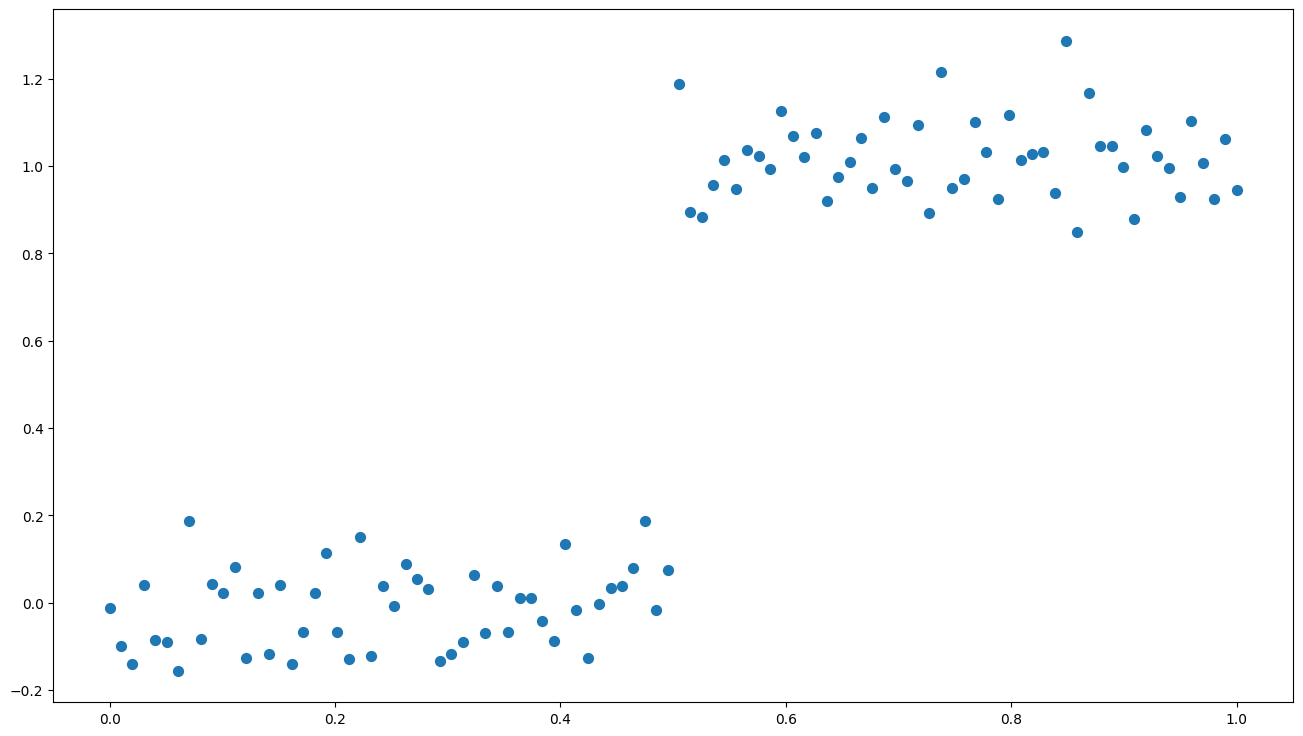

In [2]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)
plt.show()

Firstly, let's take bagging of decision trees algorithm.

Here, the ensemble size is being gradually increased.
Let's look at how the prediction depends on the size.

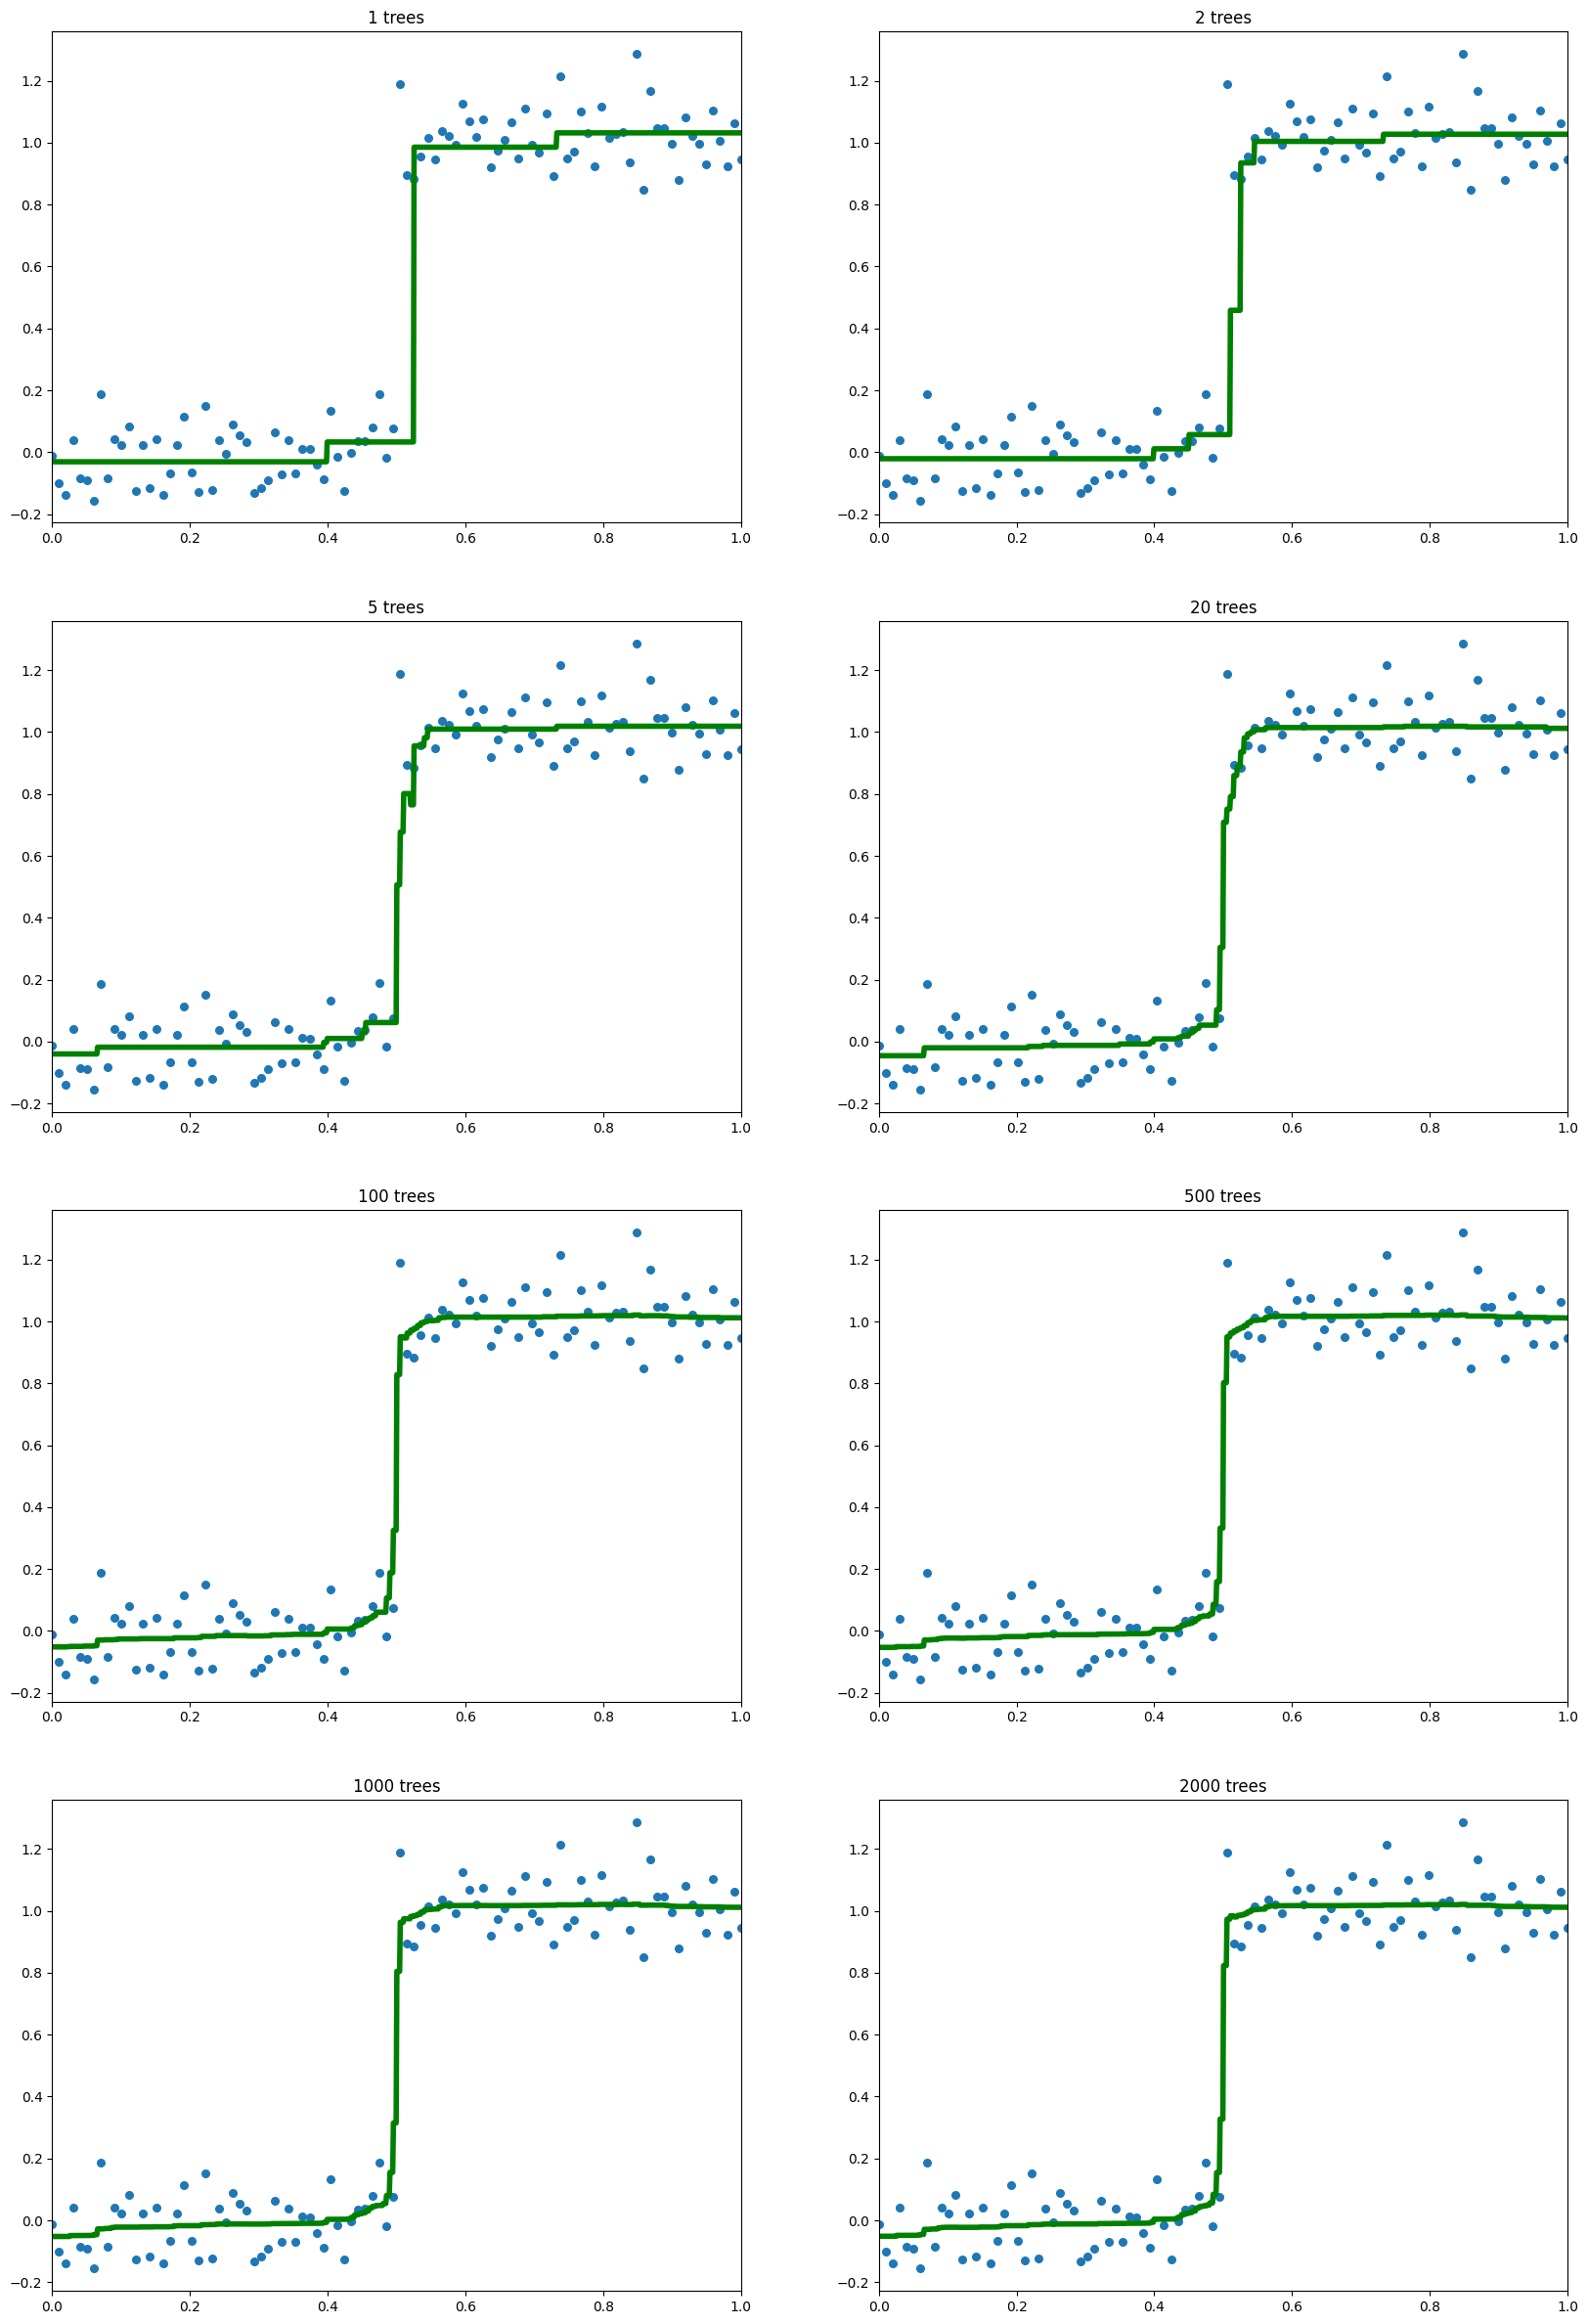

In [3]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

You can see that after a certain point the overall prediction does not change with the base learners' addition.

Now let's do the same with the gradient boosting.

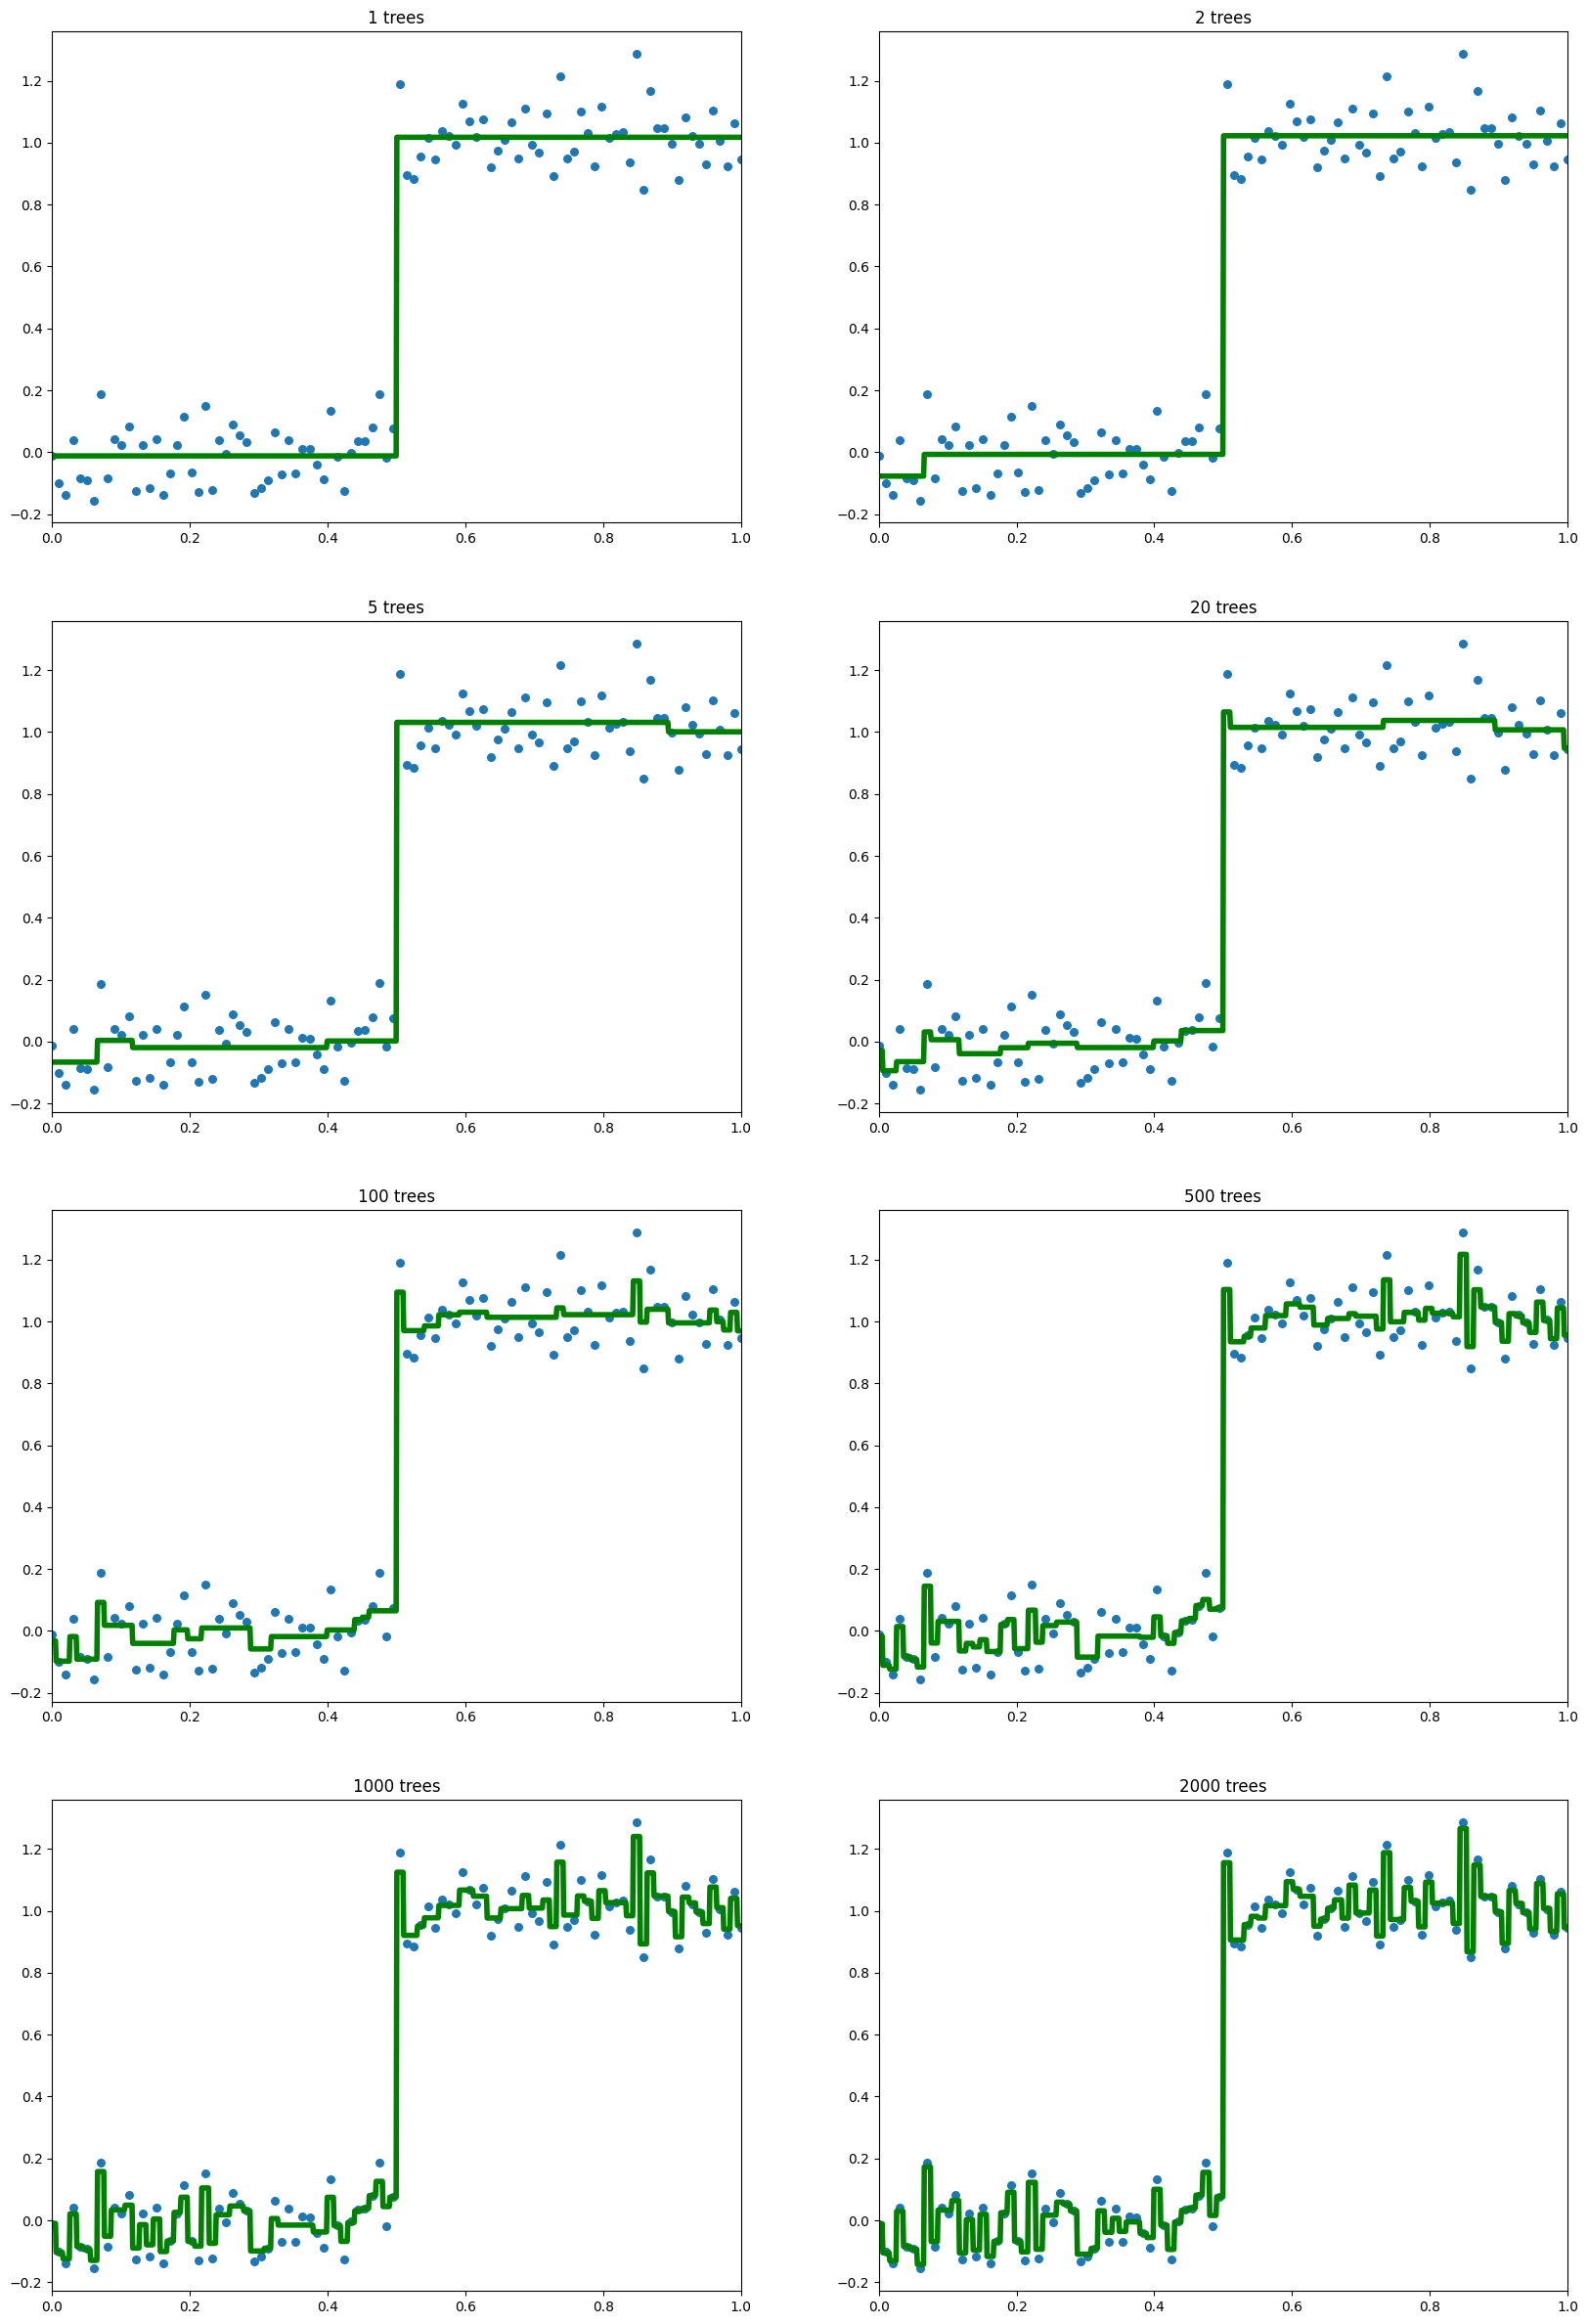

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Gradient boosting quickly captured the true dependency, but afterwards began overfitting towards individual objects from the training set. As a result, models with big ensemble sizes were severly overfitted.

One can tackle this problem by picking a very simple base learner, or intentionally lowering the weight of subsequent algorithms in the composition:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$
Here, $\eta$ is the step parameter, which controls the influence of new ensemble components.

Such an approach makes training slower compared to bagging, though, makes the final model less overfitted. Still, one should keep in mind that overfitting can happen for any $\eta$ in the limit of infinite ensemble size.


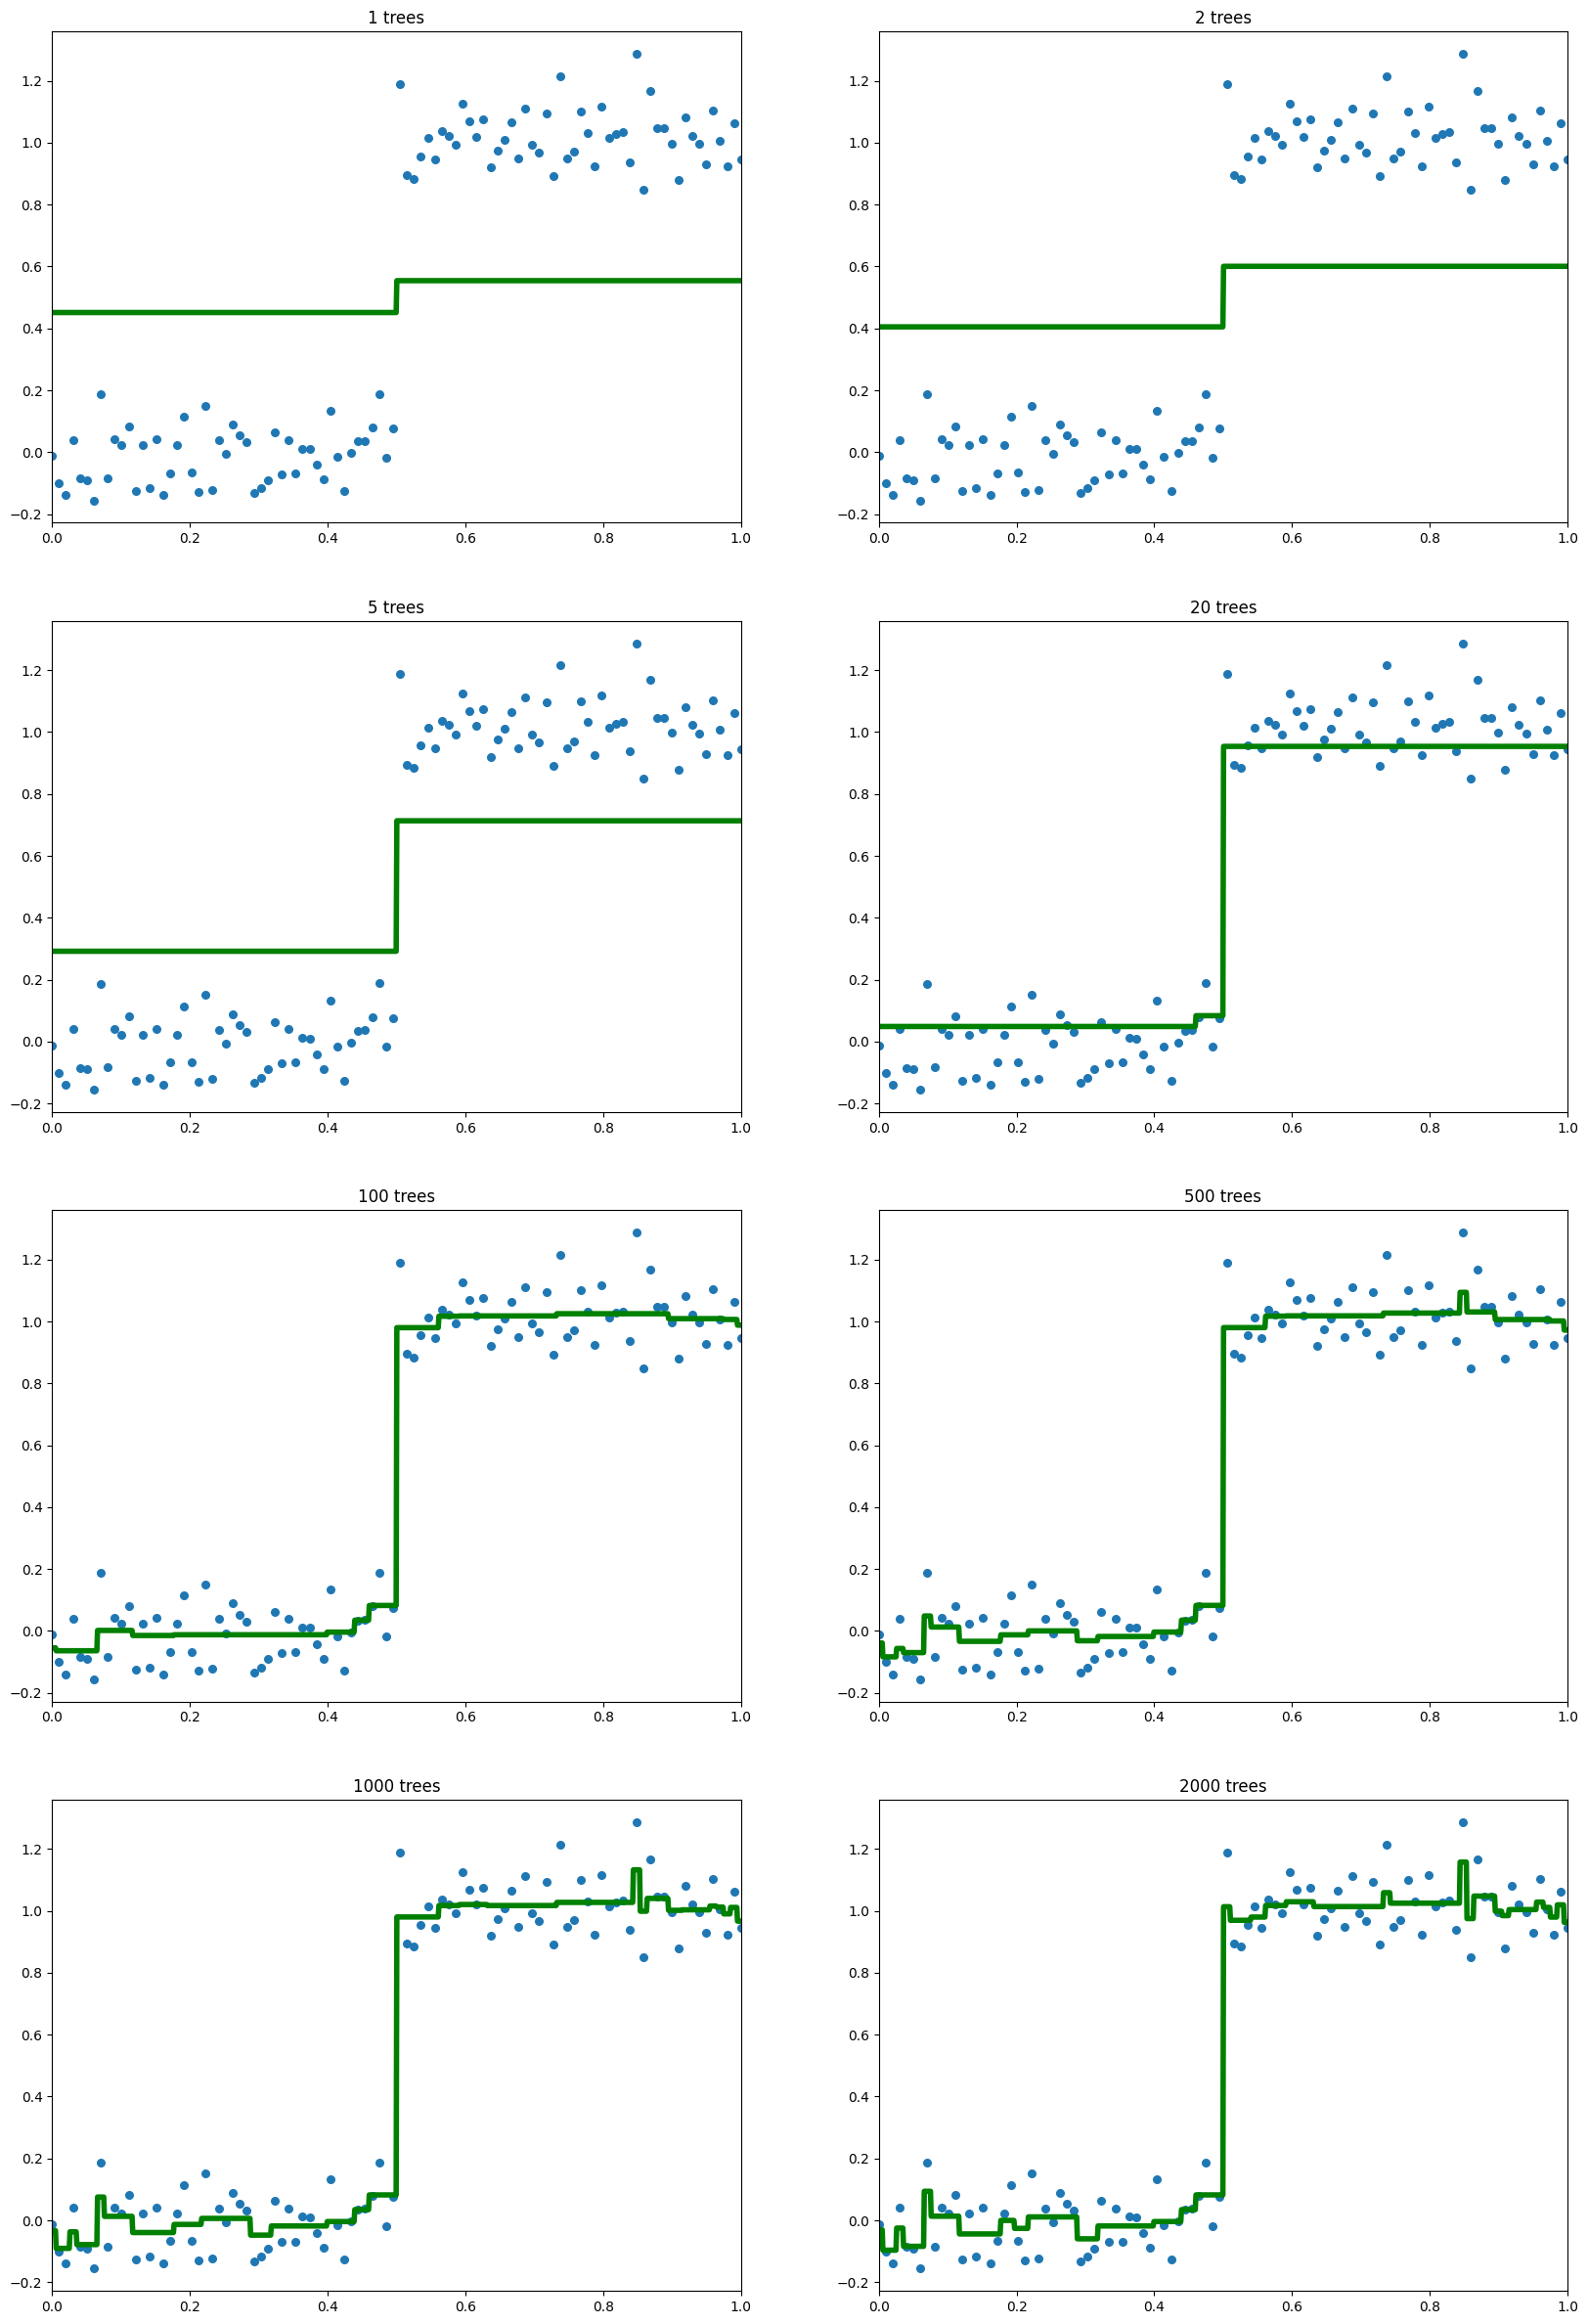

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Let's look at the described phenomenon on a more realistic dataset.

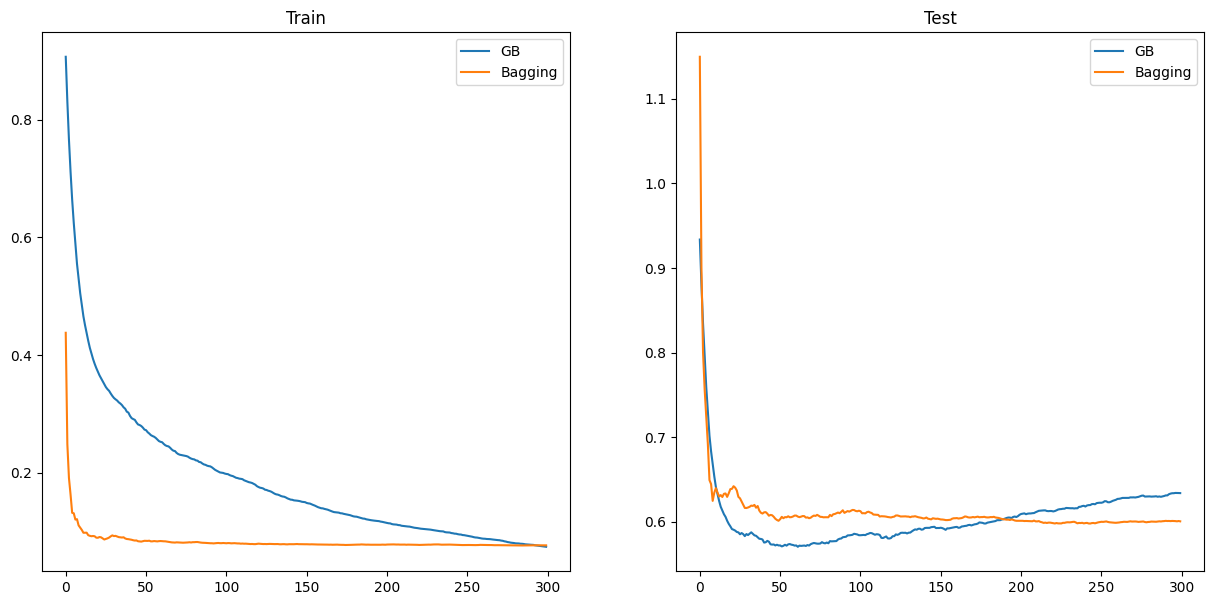

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

gbclf = GradientBoostingRegressor(warm_start=True, max_depth=2, learning_rate=0.1)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.gcf().set_size_inches(15,7)

## Part 2. Multilabel classification with Decision Trees, Random Forests, and Gradient Boosting.

In the second part of our practice session, we will apply each method to the classification task and do optimal model selection.

In [7]:
from sklearn.datasets import load_digits

data = load_digits()
X = data.data
y = data.target

We're going to use the digits dataset. This is a task of recognizing hand-written digits - a multilabel classification into 10 classes.

In [8]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

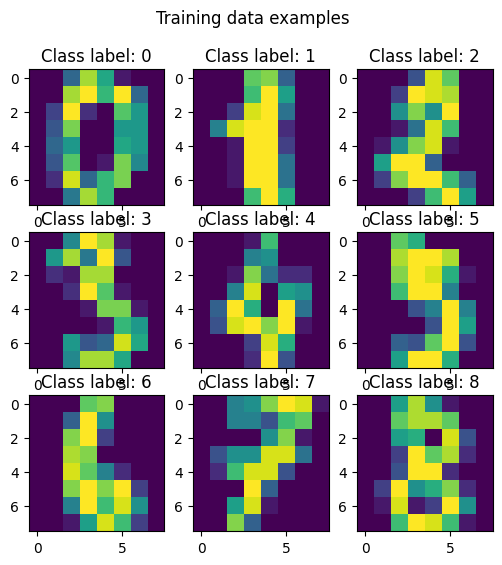

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(6, 6))
fig.suptitle("Training data examples")

for i in range(9):
    img = X[i].reshape(8, 8)
    axs[i // 3, i % 3].imshow(img)
    axs[i // 3, i % 3].set_title("Class label: %s" % y[i])

Firstly, split the dataset in order to be able to validate your model.

**Hint**: use sklearn's `ShuffleSplit` or `train_test_split`.

In [19]:
# Split the dataset. Use any method you prefer
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### Decision trees

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Create and fit decision tree with the default parameters
# Evaluate it on the validation set. Use accuracy

In [23]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

pred = tree.predict(X_test)

In [24]:
print(f'accuracy score: {accuracy_score(y_test, pred):.4f}')

accuracy score: 0.8578


#### Random forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Create RandomForestClassifier with the default parameters
# Fit and evaluate

In [34]:
forest = RandomForestClassifier()

forest.fit(X_train, y_train)

pred = forest.predict(X_test)

In [35]:
print(f'accuracy score: {accuracy_score(y_test, pred):.4f}')

accuracy score: 0.9778


In [13]:
# Now let's see how the quality depends on the number of models in the ensemble
# For each value in [5, 10, 100, 500, 1000] create a random forest with the corresponding size, fit a model and evaluate
# How does the quality change? What number is sufficient?
# Please write you conslusions

#### Gradient boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

# Create GradientBoostingClassifier with the default parameters
# Fit and evaluate. Compare its quality to random forest

In [36]:
gboost = GradientBoostingClassifier()

gboost.fit(X_train, y_train)

pred = gboost.predict(X_test)

In [37]:
print(f'accuracy score: {accuracy_score(y_test, pred):.4f}')

accuracy score: 0.9778


In [15]:
# Now let's see how the quality depends on the number of models in the ensemble
# For each value in [5, 10, 100, 500, 1000] train a gradient boosting with the corresponding size
# How does the quality change? What number is sufficient?
# Please write you conslusions

## XGBoost

[Features](https://arxiv.org/pdf/1603.02754.pdf):

1. Parallelization, optimization and sparse/missing data support

2. Base algorithm approximates the direction, computred using second-order loss function derivatives.

3. Regularized Learning Objective: penalty for leaf number and coefficient norms are added.

4. Weighted Quantile Sketch algorithm proposed to select tree node split points.


##### Installation

http://xgboost.readthedocs.io/en/latest/build.html


In [20]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {
    'max_depth': 3,  # max tree depth
    'eta': 0.3,  # learning rate / step size
    'silent': 1,  # log verbosity
    'objective': 'multi:softprob',  # objective function (in this case for multiclass classification task)
    'num_class': 10}  # number of classes
num_round = 20  # boosting iteration num

bst = xgb.train(param, dtrain, num_round)

preds = bst.predict(dtest)
best_preds = np.asarray([np.argmax(line) for line in preds])

[12:41:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [21]:
print(f'accuracy score: {accuracy_score(y_test, best_preds):.4f}')

accuracy score: 0.9644
